In [1]:
#!pip install ipywidgets

# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# Progress bar
from tqdm import tqdm
# Will use this to figure out the number of CPUs available
import multiprocessing

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = torchvision.datasets.MNIST('data_train/', download=True, train=True, transform=transform)
test_set = torchvision.datasets.MNIST('data_test/', download=True, train=False, transform=transform)

# Create test set and define test dataloader
## YOUR CODE HERE ##
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**transforms.ToTensor() converts images into Torch tensors (numeric values that reflect color channels, number of pixels).**

**transforms.Normalize() normalizes each tensor with a mean and standard deviation.**

**I did not flatten the tensors as part of my preprocessing. I will use Flatten layer in my network architecture further down.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

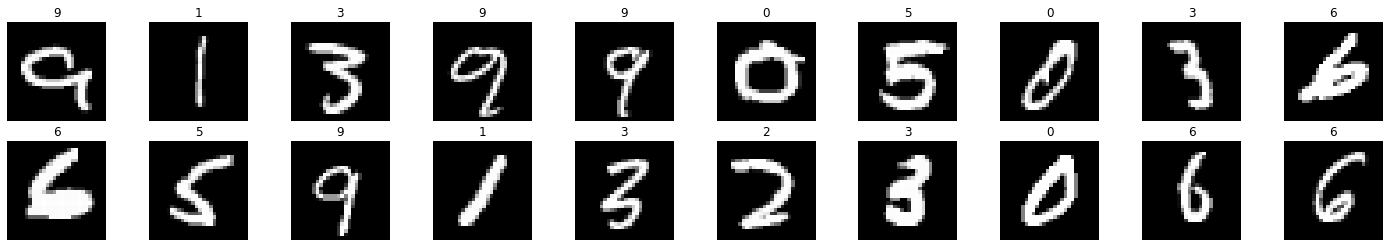

In [16]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(np.arange(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


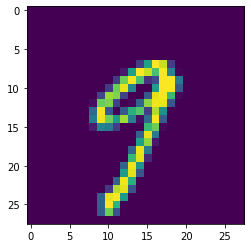

4


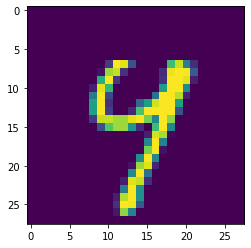

2


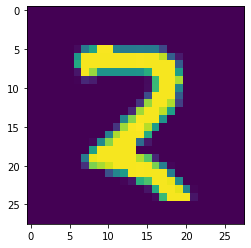

3


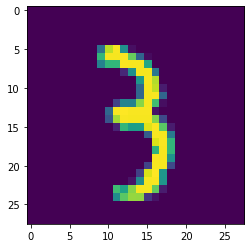

7


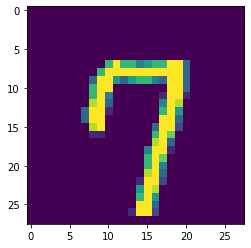

In [7]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

View an Image in More Detail

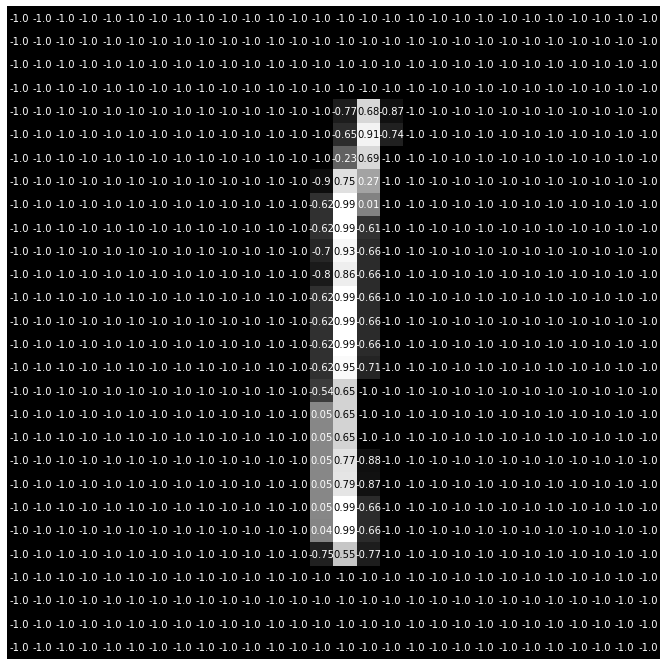

In [18]:
img = np.squeeze(images[1])

fig, sub = plt.subplots(figsize = (12,12)) 
sub.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        sub.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
        sub.axis("off")

Shape of train data

In [10]:
images = enumerate(train_loader)
batches, (example_img, example_class) = next(images)
example_img.shape

torch.Size([100, 1, 28, 28])

Shape of test data

In [9]:
images = enumerate(test_loader)
batches, (example_img, example_class) = next(images)
example_img.shape

torch.Size([100, 1, 28, 28])

**The images are 28 x 28 pixels, we will need this info for the input layer shape**

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [21]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        #self.dropout = F.dropout(0.5)
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return F.log_softmax(x, dim=1)

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [15]:
## YOUR CODE HERE ##
# Choose an optimizer

#optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum = 0.9)

# Choose a loss function

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [16]:
## YOUR CODE HERE ##
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
test_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

#    test_loss = 0.0
#    test_correct = 0
#    net.eval()
#    for inputs, labels in test_loader:
#        inputs, labels = inputs.to(device), labels.to(device)

#        outputs = net(inputs)
#        loss = criterion(outputs, labels)

#        _, preds = torch.max(outputs.data, 1)
#        test_correct += (preds == labels).sum().item()
#        test_loss += loss.item()
#    print(f'Epoch {epoch + 1} validation accuracy: {test_correct/len(test_loader):.2f}% validation loss: {test_loss/len(test_loader):.5f}')
#    test_loss_history.append(test_loss/len(test_loader))

Epoch 1 training accuracy: 86.26% training loss: 0.43847
Epoch 2 training accuracy: 94.46% training loss: 0.18227
Epoch 3 training accuracy: 95.54% training loss: 0.14588
Epoch 4 training accuracy: 96.11% training loss: 0.12562
Epoch 5 training accuracy: 96.70% training loss: 0.10662
Epoch 6 training accuracy: 97.05% training loss: 0.09661
Epoch 7 training accuracy: 97.22% training loss: 0.09112
Epoch 8 training accuracy: 97.45% training loss: 0.08207
Epoch 9 training accuracy: 97.53% training loss: 0.07870
Epoch 10 training accuracy: 97.72% training loss: 0.07384


Plot the training loss (and validation loss/accuracy, if recorded).

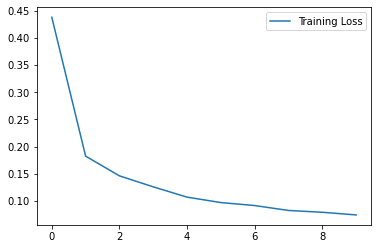

In [17]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
#plt.plot(test_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
## YOUR CODE HERE ##
test_loss = 0.0
test_correct = 0
net.eval()

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()
    test_loss += loss.item()

print(f'Test accuracy: {test_correct/len(test_loader):.2f}% test loss: {test_loss/len(test_loader):.5f}')

Test accuracy: 96.75% test loss: 0.11617


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set! You can also add a validation set into your training.

In [19]:
## YOUR CODE HERE ##
# I consistently got my accuracy between 60 and 85%. 
# Tweaking hyperparameters (batch size, optymization method, loss function,
# as well as learning rate and momentum, cf. above)
# allowed me to score over 90%

## Saving your model
Using `torch.save`, save your model for future loading.

In [29]:
## YOUR CODE HERE ##
torch.save(net,'MNIST_model')

**The following is not a part of a project, this is copied from a posterior Udacity lesson for comparison purposes as well as for a different way to define model architecture and visualize the data**

In [6]:
# number of subprocesses to use for data loading
# We set this equal to the number of CPUs available
# in this machine
num_workers = multiprocessing.cpu_count()

### Split train data into a proper training set and a validation set

In [7]:
# Split in train and validation
# NOTE: we set the generator with a fixed random seed for reproducibility
train_len = int(len(train_set) * 0.8)
val_len = len(train_set) - train_len
print(f"Using {train_len} examples for training and {val_len} for validation")
train_subset, val_subset = torch.utils.data.random_split(
    train_set, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=100, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=100, num_workers=num_workers
)

print(f"Using {len(test_set)} for testing")

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [8]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        dropout = 0.3

        self.model = nn.Sequential(
            nn.Linear(28 * 28, hidden_1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_2, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)


# Instantiate the model
model = MyModel()

# NOTE: this is NOT the structure of the network, but merely a
# visualization of the layers that are present. For very simple
# architectures the two might be similar, but for more complicated
# network they will not. See the next cell for a possible way of
# visualizing the real structure of the network
model.to(device)

MyModel(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

### (Bonus: visualize the structure of your network)
You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "mnist_network.pt" in this directory), then download the produced `mnist_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [24]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "mnist_network.pt")

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [9]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

In [10]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch_idx, (data, target) in tqdm(
            enumerate(train_loader),
            desc="Training",
            total=len(train_loader),
            leave=True,
            ncols=80,
        ):
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Validate
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(val_loader),
            desc="Validating",
            total=len(val_loader),
            leave=True,
            ncols=80,
        ):

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # =
            # 2. calculate the loss
            loss_value = criterion(output, target)  # =

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )
    
    print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}")

Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 34.72it/s]

Epoch 1: training loss 1.41253, valid loss 0.63281



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 29.99it/s]

Epoch 2: training loss 0.48073, valid loss 0.41980



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 28.08it/s]

Epoch 3: training loss 0.37343, valid loss 0.36412



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 30.38it/s]

Epoch 4: training loss 0.33237, valid loss 0.33646



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 26.86it/s]

Epoch 5: training loss 0.30742, valid loss 0.31686



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.38it/s]

Epoch 6: training loss 0.28886, valid loss 0.30354



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 27.90it/s]


Epoch 7: training loss 0.27314, valid loss 0.28725


Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 29.48it/s]

Epoch 8: training loss 0.25852, valid loss 0.27555



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.13it/s]

Epoch 9: training loss 0.24580, valid loss 0.26189



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.10it/s]

Epoch 10: training loss 0.23325, valid loss 0.25027



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 34.10it/s]

Epoch 11: training loss 0.22150, valid loss 0.23789



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.71it/s]

Epoch 12: training loss 0.21115, valid loss 0.23247



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.76it/s]

Epoch 13: training loss 0.20109, valid loss 0.22076



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 38.32it/s]

Epoch 14: training loss 0.19219, valid loss 0.21310



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 29.54it/s]

Epoch 15: training loss 0.18363, valid loss 0.20385



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 39.81it/s]

Epoch 16: training loss 0.17567, valid loss 0.19833



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.90it/s]

Epoch 17: training loss 0.16801, valid loss 0.19239



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.24it/s]

Epoch 18: training loss 0.16133, valid loss 0.18899



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 33.62it/s]

Epoch 19: training loss 0.15453, valid loss 0.18035



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 33.55it/s]

Epoch 20: training loss 0.14851, valid loss 0.17609



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 29.85it/s]

Epoch 21: training loss 0.14293, valid loss 0.17090



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 25.64it/s]

Epoch 22: training loss 0.13768, valid loss 0.16565



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 39.76it/s]

Epoch 23: training loss 0.13263, valid loss 0.16152



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 38.32it/s]

Epoch 24: training loss 0.12824, valid loss 0.15815



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.55it/s]

Epoch 25: training loss 0.12422, valid loss 0.15632



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.07it/s]

Epoch 26: training loss 0.11956, valid loss 0.15110



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 24.43it/s]

Epoch 27: training loss 0.11596, valid loss 0.14754



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.80it/s]

Epoch 28: training loss 0.11213, valid loss 0.14354



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 26.85it/s]

Epoch 29: training loss 0.10877, valid loss 0.13995



Validating: 100%|█████████████████████████████| 120/120 [00:05<00:00, 21.34it/s]

Epoch 30: training loss 0.10561, valid loss 0.13743



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 27.86it/s]


Epoch 31: training loss 0.10234, valid loss 0.13630


Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 36.03it/s]

Epoch 32: training loss 0.09941, valid loss 0.13569



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.02it/s]

Epoch 33: training loss 0.09666, valid loss 0.12911



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 34.75it/s]

Epoch 34: training loss 0.09390, valid loss 0.13102



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 29.62it/s]

Epoch 35: training loss 0.09106, valid loss 0.12694



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.42it/s]

Epoch 36: training loss 0.08902, valid loss 0.12701



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.99it/s]

Epoch 37: training loss 0.08632, valid loss 0.12233



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 24.59it/s]

Epoch 38: training loss 0.08404, valid loss 0.12247



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.52it/s]

Epoch 39: training loss 0.08220, valid loss 0.11799



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 24.07it/s]

Epoch 40: training loss 0.07995, valid loss 0.11966



Validating: 100%|█████████████████████████████| 120/120 [00:05<00:00, 20.17it/s]

Epoch 41: training loss 0.07820, valid loss 0.11601



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 27.60it/s]

Epoch 42: training loss 0.07595, valid loss 0.11382



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 36.59it/s]

Epoch 43: training loss 0.07437, valid loss 0.11291



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 34.16it/s]

Epoch 44: training loss 0.07250, valid loss 0.11156



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.46it/s]

Epoch 45: training loss 0.07099, valid loss 0.10971



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 24.80it/s]

Epoch 46: training loss 0.06925, valid loss 0.11554



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 30.80it/s]

Epoch 47: training loss 0.06756, valid loss 0.10942



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.96it/s]

Epoch 48: training loss 0.06639, valid loss 0.10731



Validating: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.27it/s]

Epoch 49: training loss 0.06481, valid loss 0.10855



Validating: 100%|█████████████████████████████| 120/120 [00:04<00:00, 26.98it/s]

Epoch 50: training loss 0.06336, valid loss 0.10797


### Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [11]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval()  # prep model for *evaluation*

for batch_idx, (data, target) in tqdm(
    enumerate(test_loader),
    desc="Testing",
    total=len(test_loader),
    leave=True,
    ncols=80,
):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(10):
    if class_total[i] > 0:
        print(
            f"Test Accuracy of {i}: {100 * class_correct[i] / class_total[i]:.2f}%% "
            f"({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})"
        )
    else:
        print(f"Test Accuracy of {classes[i]}: N/A (no training examples)")

print(
    f"\nTest Accuracy (Overall): {100.0 * np.sum(class_correct) / np.sum(class_total)}%% "
    f"({int(np.sum(class_correct))}/{int(np.sum(class_total))})"
)

Testing: 100%|████████████████████████████████| 100/100 [00:06<00:00, 15.47it/s]

Test Loss: 0.091163

Test Accuracy of 0: 98.16%% (962/980)
Test Accuracy of 1: 98.85%% (1122/1135)
Test Accuracy of 2: 97.38%% (1005/1032)
Test Accuracy of 3: 97.03%% (980/1010)
Test Accuracy of 4: 98.07%% (963/982)
Test Accuracy of 5: 96.52%% (861/892)
Test Accuracy of 6: 96.87%% (928/958)
Test Accuracy of 7: 95.62%% (983/1028)
Test Accuracy of 8: 98.05%% (955/974)
Test Accuracy of 9: 94.35%% (952/1009)

Test Accuracy (Overall): 97.11%% (9711/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

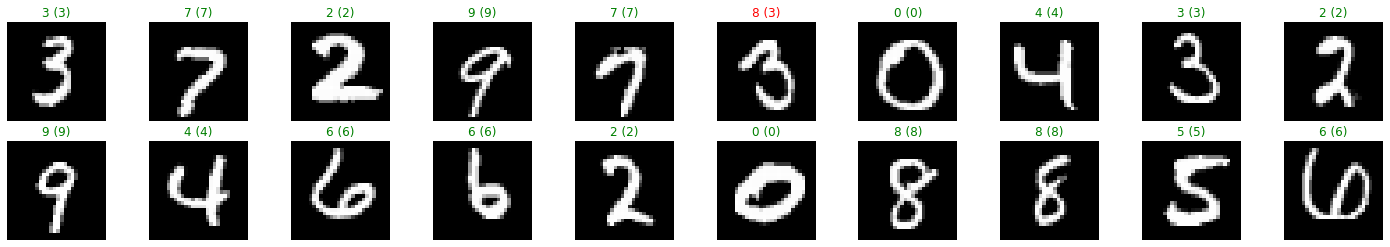

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(range(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    sub.set_title(f"{str(preds[idx].item())} ({str(labels[idx].item())})",
                 color=("green" if preds[idx]==labels[idx] else "red"))
    sub.axis("off")

## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
## YOUR CODE HERE ##
torch.save(model,'MNIST_model_dropout')